In [1]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import os
from transformers.trainer_utils import get_last_checkpoint
from transformers import Trainer, TrainingArguments
import json
import torch

# Load Train and dev datasets

In [2]:
with open(r"C:\Users\latif\Desktop\projetFouille\data\train-v2.0.json", encoding="utf-8") as f:
    squad_train = json.load(f)
with open(r"C:\Users\latif\Desktop\projetFouille\data\dev-v2.0.json", encoding="utf-8") as f:
    squad_dev = json.load(f)

# Function to extract Context, Question and Answer

In [3]:
def extract_information(squad_json):
    contexts = []
    questions = []
    answers = []

    for article in squad_json["data"]:
        for paragraph in article["paragraphs"]:
            context = paragraph["context"]

            for qa in paragraph["qas"]:
                question = qa["question"]

                # CAS 1 : question avec réponse
                if len(qa["answers"]) > 0:
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]

                # CAS 2 : question sans réponse
                else:
                    answer_text = ""
                    answer_start = 0

                contexts.append(context)
                questions.append(question)
                answers.append({
                    "text": answer_text,
                    "answer_start": answer_start
                })

    return contexts, questions, answers

In [4]:
contexts,questions,answers= extract_information(squad_train)
contexts_dev,questions_dev,answers_dev= extract_information(squad_dev)

# Analysis of train Dataset

In [95]:
def proportion_questions_avec_sans_reponse(answers):
    total = len(answers)

    sans_reponse = sum(1 for a in answers if a["text"] == "")
    avec_reponse = total - sans_reponse

    prop_sans = sans_reponse / total if total > 0 else 0
    prop_avec = avec_reponse / total if total > 0 else 0

    return {
        "total": total,
        "avec_reponse": avec_reponse,
        "sans_reponse": sans_reponse,
        "proportion_avec_reponse": prop_avec,
        "proportion_sans_reponse": prop_sans
    }

In [96]:
contexts, questions, answers = extract_information(squad_train)
stats = proportion_questions_avec_sans_reponse(answers)
print("Total questions :", stats["total"])
print("Avec réponse :", stats["avec_reponse"])
print("Sans réponse :", stats["sans_reponse"])
print("Proportion avec réponse :", round(stats["proportion_avec_reponse"] * 100, 2), "%")
print("Proportion sans réponse :", round(stats["proportion_sans_reponse"] * 100, 2), "%")

Total questions : 130319
Avec réponse : 86821
Sans réponse : 43498
Proportion avec réponse : 66.62 %
Proportion sans réponse : 33.38 %


In [104]:
import matplotlib.pyplot as plt

def plot_pie_questions_avec_sans_reponse(answers):
    total = len(answers)
    sans_reponse = sum(1 for a in answers if a["text"] == "")
    avec_reponse = total - sans_reponse

    labels = ["With answer", "Without answer"]
    sizes = [avec_reponse, sans_reponse]

    plt.figure()
    plt.pie(
        sizes,
        labels=labels,
        autopct="%1.1f%%",
        startangle=90
    )
    plt.title("Proportion of questions with / withouts answer")
    plt.axis("equal")  # cercle parfait
    plt.show()


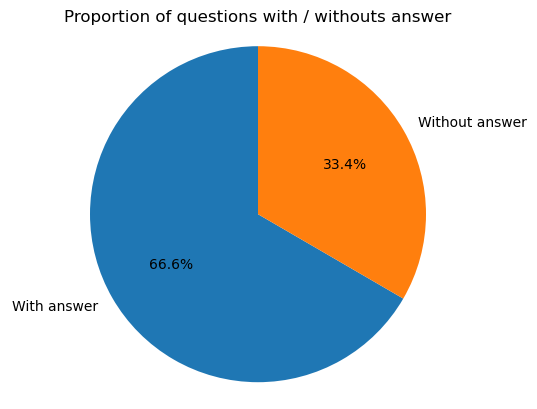

In [105]:
plot_pie_questions_avec_sans_reponse(answers)

In [109]:
def hist_longueur_texts(texts, nom, key=None):
    if key:
        texts_clean = [t[key] for t in texts if isinstance(t, dict) and key in t]
    else:
        texts_clean = [t for t in texts if isinstance(t, str)]

    lengths = [len(t.split()) for t in texts_clean]

    plt.figure(figsize=(8,5))
    plt.hist(lengths, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel(f"Number of words in {nom}")
    plt.ylabel(f"Number of {nom}")
    plt.title(f"Distribution of lengths {nom}")
    plt.show()

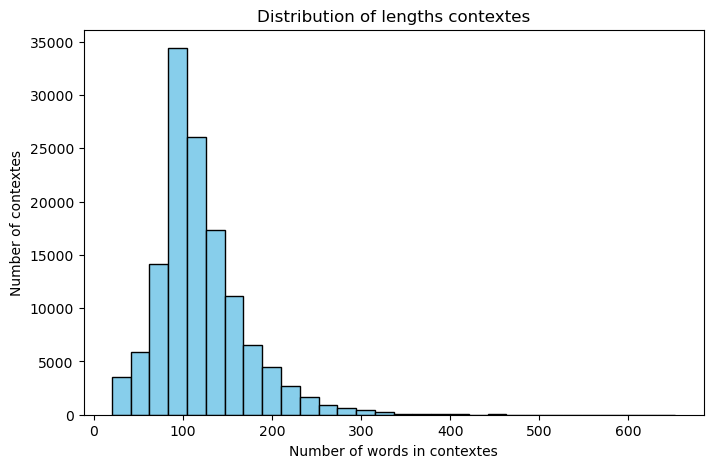

In [110]:
hist_longueur_texts(contexts,"contextes")

In [ ]:
#The analysis of the context length distribution shows that most contexts contain approximately 100 words, 
#with moderate dispersion and a long tail toward longer contexts. In this case, there is no need for a very large maximum length.

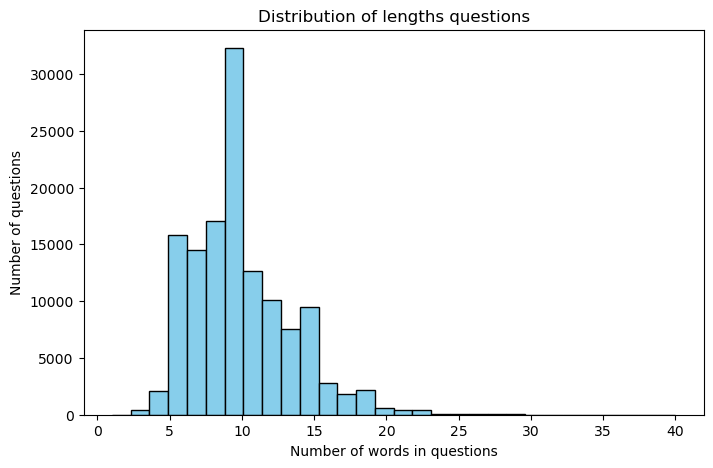

In [111]:
hist_longueur_texts(questions,"questions")

In [ ]:
#The distribution of question lengths shows that most questions are relatively short, typically between 5 and 15 words, with a peak around 8–10 words. 
#The distribution exhibits moderate dispersion and a long tail toward longer questions, extending up to around 40 words.
#This indicates that a large maximum sequence length is not necessary for questions.

In [5]:
model_name = "albert-base-v2"  # ou "albert-base-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

Loading weights:   0%|          | 0/23 [00:00<?, ?it/s]

AlbertForQuestionAnswering LOAD REPORT from: albert-base-v2
Key                          | Status     | 
-----------------------------+------------+-
predictions.LayerNorm.weight | UNEXPECTED | 
predictions.dense.weight     | UNEXPECTED | 
predictions.decoder.bias     | UNEXPECTED | 
predictions.LayerNorm.bias   | UNEXPECTED | 
predictions.dense.bias       | UNEXPECTED | 
albert.pooler.weight         | UNEXPECTED | 
predictions.bias             | UNEXPECTED | 
albert.pooler.bias           | UNEXPECTED | 
qa_outputs.bias              | MISSING    | 
qa_outputs.weight            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


# Preprcosessing

In [6]:
def prepare_qa_inputs(batch):
    # Handle Missing Values
    questions = [q if q is not None else "" for q in batch["question"]]
    contexts = [c if c is not None else "" for c in batch["context"]]
    answers = batch["answers"]

    inputs = tokenizer(
        questions,
        contexts,
        max_length=256,           # Limits total tokens (question + context) for faster training and Matching histogram Analysis.
        truncation="only_second", # Cut context if too long but never cut questions
        stride=128,               # When context > 256 tokens, creates overlapping chunks
        return_overflowing_tokens=True,   # Which chunk belongs to which original sample
        return_offsets_mapping=True,      # token → original character position in context
        padding="max_length"              # Ensures all inputs have same length (256 tokens).
    )

    # 
    sample_mapping = inputs.pop("overflow_to_sample_mapping")
    offset_mapping = inputs.pop("offset_mapping")

    start_positions = []
    end_positions = []
    
    for i, offsets in enumerate(offset_mapping):  #Loop Over Tokenized Chunks
        sample_idx = sample_mapping[i]            #Find Which Original Sample This Chunk Belongs To
        answer = answers[sample_idx]

        if len(answer["text"]) == 0 or answer["text"][0] == "": #Find Which Original Sample This Chunk Belongs To
            start_positions.append(0)
            end_positions.append(0)
            continue

        start_char = answer["answer_start"][0]            
        end_char = start_char + len(answer["text"][0]) 
        sequence_ids = inputs.sequence_ids(i)

        start_pos, end_pos = 0, 0
        for idx, (start, end) in enumerate(offsets): #Loop Over Tokens
            if sequence_ids[idx] != 1: #Skip Non-Context Tokens
                continue
            if start <= start_char < end: # Detect Start Token
                start_pos = idx
            if start < end_char <= end: #Detect End Token
                end_pos = idx
        # Save results
        start_positions.append(start_pos)
        end_positions.append(end_pos)
     #Add Labels To Model Inputs
    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions

    return inputs

# Tokenisation of datasets

In [7]:
from datasets import Dataset

formatted_answers = [
    {
        "text": [a["text"]],
        "answer_start": [a["answer_start"]]
    }
    for a in answers
]


formatted__dev_answers = [
    {
        "text": [a["text"]],
        "answer_start": [a["answer_start"]]
    }
    for a in answers_dev
]

train_dataset = Dataset.from_dict({
    "context": contexts,
    "question": questions,
    "answers": formatted_answers
})

dev_dataset = Dataset.from_dict({
    "context": contexts_dev,
    "question": questions_dev,
    "answers": formatted__dev_answers
})

In [119]:
# Deviding dev dataset to validation and test 
split2 = dev_dataset.train_test_split(test_size=0.7)
val_dataset = split2['train']   
test_dataset = split2['test']   

#Tokenisation of datasets
tokenized_train = train_dataset.map(
    prepare_qa_inputs,
    batched=True,
    remove_columns=train_dataset.column_names
)
tokenized_val = dev_dataset.map(
    prepare_qa_inputs,
    batched=True,
    remove_columns=val_dataset.column_names
)
tokenized_test = dev_dataset.map(
    prepare_qa_inputs,
    batched=True,
    remove_columns=test_dataset.column_names
)

Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [94]:
print(len(train_dataset))  # nombre d'exemples dans le dataset d'entraînement
print(len(dev_dataset))    # nombre d'exemples dans le dataset de validation/dev
print(len(test_dataset))   # nombre d'exemples dans le dataset de test

130319
11873
8312


# Model Training

In [15]:
training_args = TrainingArguments(
    output_dir="./albert_qa_model",

    # CHECKPOINTING
    save_strategy="steps",        
    save_steps=2000,              # save every 2000 steps
    save_total_limit=2,           # keep only last 2 checkpoints

    # TRAINING
    learning_rate=3e-5,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4, # accumulate gradients over 4 steps
    num_train_epochs=1,
    max_steps=8000,   # Choose 8000 steps for CPU limitations (in my case)

    # LOGGING
    logging_steps=1000,

    # SPEED
    eval_strategy="no"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val
)


last_checkpoint = get_last_checkpoint("./albert_qa_model")

if last_checkpoint is not None:
    trainer.train(resume_from_checkpoint=last_checkpoint)
else:
    trainer.train()



Step,Training Loss
1000,3.471033
2000,2.885102
3000,2.721371
4000,2.377163
5000,2.253403
6000,2.163834
7000,2.227295
8000,2.010065


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
import os

os.listdir("./albert_qa_model")


['checkpoint-6000', 'checkpoint-8000']

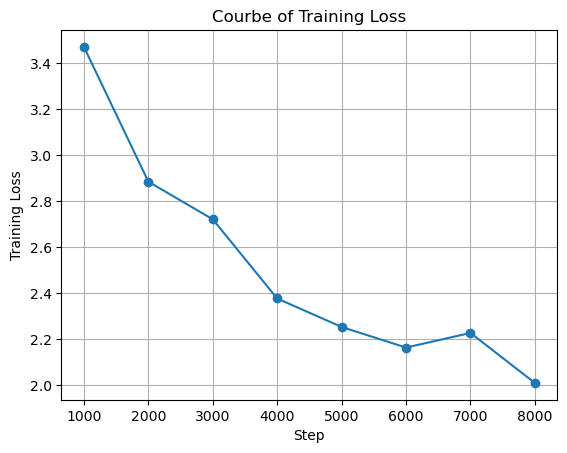

In [112]:
import matplotlib.pyplot as plt

steps = [1000, 2000, 3000, 4000, 5000, 6000,7000,8000]
losses = [3.471033, 2.885102, 2.721371, 2.377163, 2.253403, 2.163834,2.227295,2.010065]

plt.plot(steps, losses, marker='o')
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("Courbe of Training Loss")
plt.grid(True)
plt.show()


# Model Evaluation 

In [22]:


checkpoint_path = os.path.abspath("./albert_qa_model/checkpoint-8000")

tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

model = AutoModelForQuestionAnswering.from_pretrained(
    checkpoint_path,
    local_files_only=True
)


Loading weights:   0%|          | 0/25 [00:00<?, ?it/s]

In [24]:
training_args = TrainingArguments(
    output_dir="./albert_qa_model"
)

trainer = Trainer(
    model=model,
    eval_dataset=tokenized_val
)

trainer.evaluate()


C:\Users\latif\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


{'eval_loss': 1.7375248670578003,
 'eval_model_preparation_time': 0.0008,
 'eval_runtime': 7325.1756,
 'eval_samples_per_second': 0.955,
 'eval_steps_per_second': 0.119}

In [86]:
from tqdm import tqdm
import evaluate 

#  Load model checkpoints
model_name = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained("./albert_qa_model/checkpoint-8000") 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

#Check if column id exixts
if "id" in val_dataset.column_names:
    val_dataset = val_dataset.remove_columns("id")

# Add a unique ID for every exemple
val_dataset = val_dataset.add_column("id", [str(i) for i in range(len(val_dataset))])

#Tokenisation function
def prepare_qa_inputs_with_overflow(batch):
    tokenized = tokenizer(
        batch["question"],
        batch["context"],
        max_length=256,
        truncation="only_second",
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length"
    )
    
    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    tokenized["example_id"] = sample_mapping  # permet de retrouver la question originale
    return tokenized

tokenized_val = val_dataset.map(
    prepare_qa_inputs_with_overflow,
    batched=True,
    remove_columns=val_dataset.column_names
)

# Load of Squad Metric
metric = evaluate.load("squad")

# Made prédictions
predictions = []
for i in tqdm(range(len(tokenized_val))):
    inputs = {k: torch.tensor(tokenized_val[i][k]).unsqueeze(0).to(device)
              for k in tokenizer.model_input_names}

    with torch.no_grad():
        outputs = model(**inputs)

    start_logits = outputs.start_logits.cpu()
    end_logits = outputs.end_logits.cpu()

    start_index = start_logits.argmax(dim=-1).item()
    end_index = end_logits.argmax(dim=-1).item()

    # CORRECT answer extraction
    example_id = tokenized_val[i]["example_id"]
    context = val_dataset[example_id]["context"]
    offsets = tokenized_val[i]["offset_mapping"]

    if start_index > end_index:
        answer_text = ""
    else:
        start_char = offsets[start_index][0]
        end_char = offsets[end_index][1]

        if start_char is None or end_char is None:
            answer_text = ""
        else:
            answer_text = context[start_char:end_char]

    answer_text = answer_text.strip()

    true_answers = val_dataset[example_id]["answers"]

    predictions.append({
        "id": val_dataset[example_id]["id"],
        "prediction_text": answer_text,
        "answers": true_answers
    })

# Compute metriques EM et F1
formatted_predictions = [{"id": p["id"], "prediction_text": p["prediction_text"]} for p in predictions]
references = [{"id": p["id"], "answers": p["answers"]} for p in predictions]

final_score = metric.compute(predictions=formatted_predictions, references=references)

# Save results

results_dict = {
    "model": "albert-base-v2",
    "checkpoint": "checkpoint-8000",
    "exact_match": final_score["exact_match"],
    "f1": final_score["f1"]
}

with open("./albert_qa_model/evaluation_results3.json", "w", encoding="utf-8") as f:
    json.dump(results_dict, f, indent=4, ensure_ascii=False)
    
# Show results
print("Evaluation terminée !")
print("Exact Match (EM):", final_score["exact_match"])
print("F1 Score:", final_score["f1"])

# print("Evaluation terminée !")
# print("Exact Match (EM):", final_score["exact_match"])
# print("F1 Score:", final_score["f1"])


Loading weights:   0%|          | 0/25 [00:00<?, ?it/s]

Map:   0%|          | 0/3561 [00:00<?, ? examples/s]

100%|██████████| 4184/4184 [1:35:02<00:00,  1.36s/it]


✅ Evaluation terminée !
Exact Match (EM): 26.601338432122372
F1 Score: 0.5476337565471175
✅ Evaluation terminée !
Exact Match (EM): 26.601338432122372
F1 Score: 0.5476337565471175


# Test With a context and a question

In [92]:
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# 🔹 Charger le modèle et le tokenizer
model_name = "albert-base-v2"
checkpoint_path = "./albert_qa_model/checkpoint-8000"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(checkpoint_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# 🔹 Entrer ton contexte et ta question
context = "The Eiffel Tower is a wrought-iron lattice tower in Paris, France. It was designed by Gustave Eiffel and completed in 1889. It is one of the most famous landmarks in the world"
question = "Who designed the Eiffel Tower?"

# 🔹 Tokenisation (remplacer encode_plus par tokenizer(...))
inputs = tokenizer(
    question,
    context,
    return_tensors="pt"
).to(device)

# 🔹 Prédiction
with torch.no_grad():
    outputs = model(**inputs)

start_logits = outputs.start_logits
end_logits = outputs.end_logits

# 🔹 Trouver la position de la réponse
start_index = torch.argmax(start_logits)
end_index = torch.argmax(end_logits)

# 🔹 Décoder la réponse
answer = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][start_index:end_index + 1])
)

print("Question:", question)
print("Réponse prédite:", answer)


Loading weights:   0%|          | 0/25 [00:00<?, ?it/s]

Question: Who designed the Eiffel Tower?
Réponse prédite: gustave eiffel
